Calculate limb darkening for TLUSTY BSTAR2006 model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy import constants, units
plt.style.use('lijiaonature')

In [2]:
M_H_grid = np.array([0.5, 1, 2]) # the MH is in units of Zsun
Teff_grid = np.array([15000, 16000])
logg_grid = np.array([3.5, 3.75, 4.0])

In [3]:
from exotic_ld import StellarLimbDarkening
from exotic_ld import ld_laws

In [94]:
# Path to the downloaded data.
ld_data_path = '/nfsdata/users/lijiao/exotic_ld_data/'


# Metallicty [Zsun].
M_H = 1

# Effective temperature [K].
Teff = 15000

# Surface gravity [dex].
logg = 4


In [95]:
# Start and end of wavelength interval [angstroms].
wavelength_range = [1100., 15000.]

# Instrument mode.
mode = 'TESS'

In [96]:
file_name = '/nfsdata/users/lijiao/exotic_ld_data/BSTAR2006v2/MH1.0/teff15000/logg4.0/BSTAR2006v2_spectra.dat'
mus = np.loadtxt(file_name, skiprows=1, max_rows=1)
stellar_data = np.loadtxt(file_name, skiprows=2)

custom_wavelengths = stellar_data[:, 0]
custom_stellar_model =  stellar_data[:, 1:]

hv = constants.h*constants.c/(custom_wavelengths*units.AA)
hv = hv.to('erg').value


### erg/s/cm/A/strerad --> n_phot/s/cm2/s/A/sterad
for _i in np.arange(0, 20):
    custom_stellar_model[:, _i] =custom_stellar_model[:, _i]/hv

# - calculate $I(\mu)$ from flux with unit of erg/s/cm2/s/A/sterad

In [97]:
# Stellar models grid.

ld_model = 'BSTAR2006v2'

sld_erg = StellarLimbDarkening(M_H, Teff, logg, ld_model, ld_data_path,
                          M_H_grid=M_H_grid,
                          Teff_grid = Teff_grid,
                          logg_grid = logg_grid,
                          )

coefs_erg = sld_erg.compute_4_parameter_non_linear_ld_coeffs(wavelength_range, mode)
print(coefs_erg)

(0.5566796029136055, -0.15117895592710498, 0.06168705447227217, -0.01566107712533915)


# -calculate $I(\mu)$ from flux with unit of n_phot/s/cm2/s/A/sterad of synsepc spectrum

In [98]:
ld_model = 'BSTAR2006v2_nphot'

sld_nphot = StellarLimbDarkening(M_H, Teff, logg, ld_model, ld_data_path,
                          M_H_grid=M_H_grid,
                          Teff_grid = Teff_grid,
                          logg_grid = logg_grid,
                          )

coefs_nphot= sld_nphot.compute_4_parameter_non_linear_ld_coeffs(wavelength_range, mode)
print(coefs_nphot)

(0.5620709470234887, -0.14528870683205783, 0.05615175678767099, -0.014002276472561257)


# - calculate $I(\mu)$ from flux with unit of n_phot/s/cm2/s/A/sterad of broadn synsepc spectrum (R=2000)

In [99]:
sld_nphot1 = StellarLimbDarkening(M_H=M_H, Teff=Teff, logg=logg, 
                                 custom_wavelengths=custom_wavelengths, 
                                 custom_mus=mus, 
                                 custom_stellar_model=custom_stellar_model,
                                 ld_model='custom', ld_data_path=ld_data_path)

coefs_nphot1 = sld_nphot1.compute_4_parameter_non_linear_ld_coeffs(wavelength_range, mode)
print(coefs_nphot1)

(0.5512422255214441, -0.15743411728329323, 0.06739246764399903, -0.017347480815058554)


In [100]:
cosis = np.linspace(0, 1, 60)

Text(0, 0.5, '$I(\\mu)/I(0)$')

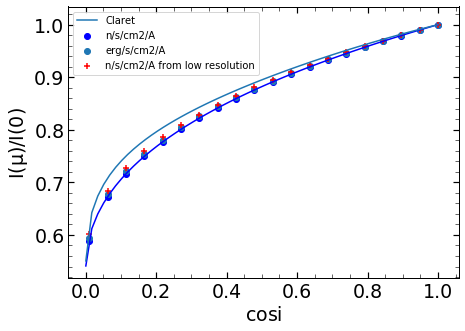

In [103]:
fig, ax = plt.subplots(1,1, figsize=(7,5))

plt.scatter(sld_nphot.mus, sld_nphot.I_mu, label='n/s/cm2/A', color='b')
plt.scatter(sld_erg.mus, sld_erg.I_mu, label='erg/s/cm2/A')

plt.scatter(sld_nphot1.mus, sld_nphot1.I_mu, label='n/s/cm2/A from low resolution', color='r', marker='+')


plt.plot(cosis, ld_laws.nonlinear_4param_ld_law(cosis, *coefs_nphot), color='b')

coefs_claret = [0.8064, -0.8792, 0.8042, -0.2820]
plt.plot(cosis, ld_laws.nonlinear_4param_ld_law(cosis, *coefs_claret), label='Claret')
plt.legend(fontsize=10)
plt.xlabel(r'$\cos i$')
plt.ylabel(r'$I(\mu)/I(0)$')